# EDA(Exploratory Data Analysis, 探索性数据分析)

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user02/anaconda3/env

# Data Split 数据分割


Distribution of Whole 2015 Data

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64


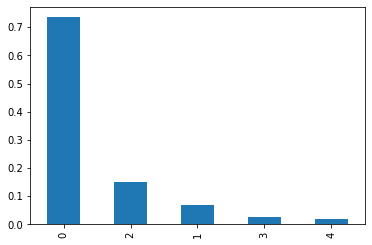

In [2]:
# 展示2015数据标签的分布情况
df_2015 = pd.read_csv('../input/aptos-data-split/df_2015_cv.csv')
print("Distribution of Whole 2015 Data\n")
print(df_2015["level"].value_counts())  # 总共35126个样本，分散为0-4级不等
df_2015["level"].value_counts(True).plot.bar()

Distribution of Whole 2019 Data

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


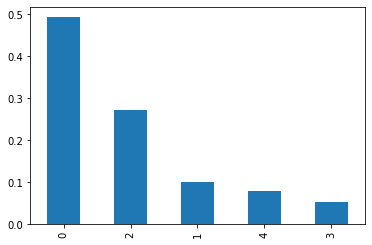

In [3]:
# 展示2019数据标签的分布情况
df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')
print("Distribution of Whole 2019 Data\n")
print(df_2019["diagnosis"].value_counts())  # 总共3662个样本，分散为0-4级不等
print(df_2019["diagnosis"].value_counts(True))
df_2019["diagnosis"].value_counts(True).plot.bar()

## Hold-out 预留

Distribution of 2015 Train/Valid

is_valid  level
False     0        0.731744
          2        0.152242
          1        0.071530
          3        0.024733
          4        0.019751
True      0        0.746940
          2        0.144321
          1        0.061628
          3        0.025334
          4        0.021776
Name: level, dtype: float64
is_valid  level
False     0        20562
          2         4278
          1         2010
          3          695
          4          555
True      0         5248
          2         1014
          1          433
          3          178
          4          153
Name: level, dtype: int64


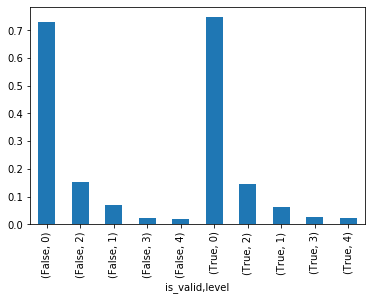

In [4]:
print("Distribution of 2015 Train/Valid\n")
print(df_2015.groupby("is_valid")["level"].value_counts("True"))
print(df_2015.groupby("is_valid")["level"].value_counts())
df_2015.groupby("is_valid")["level"].value_counts("True").plot("bar")

Distribution of 2019 Train/Valid

is_valid  diagnosis
False     0            0.490611
          2            0.274155
          1            0.100717
          4            0.079208
          3            0.055309
True      0            0.502046
          2            0.267394
          1            0.102319
          4            0.085948
          3            0.042292
Name: diagnosis, dtype: float64
is_valid  diagnosis
False     0            1437
          2             803
          1             295
          4             232
          3             162
True      0             368
          2             196
          1              75
          4              63
          3              31
Name: diagnosis, dtype: int64


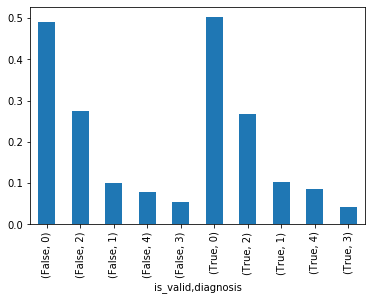

In [5]:
print("Distribution of 2019 Train/Valid\n")
print(df_2019.groupby("is_valid")["diagnosis"].value_counts("True"))  # 按20%的比例预留测试样本，保持原分级的比例
print(df_2019.groupby("is_valid")["diagnosis"].value_counts())
df_2019.groupby("is_valid")["diagnosis"].value_counts("True").plot("bar")

## Cross Validation

Distribution of 2019 Fold 1 Train/Valid

is_valid1  diagnosis
False      0            0.493333
           2            0.272821
           1            0.101197
           4            0.080342
           3            0.052308
True       0            0.491180
           2            0.272727
           1            0.100407
           4            0.081411
           3            0.054274
Name: diagnosis, dtype: float64


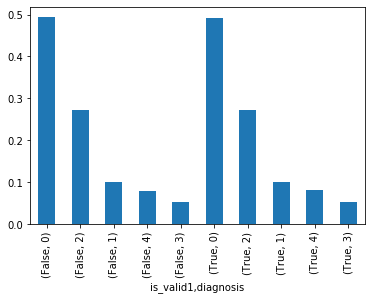

Distribution of 2019 Fold 2 Train/Valid

is_valid2  diagnosis
False      0            0.492996
           2            0.272976
           1            0.101127
           4            0.080287
           3            0.052614
True       0            0.492517
           2            0.272109
           1            0.100680
           4            0.081633
           3            0.053061
Name: diagnosis, dtype: float64


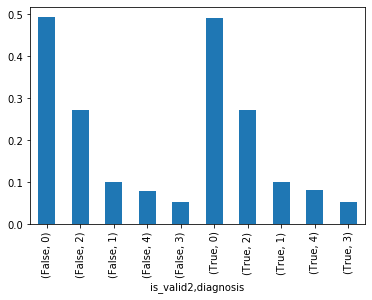

Distribution of 2019 Fold 3 Train/Valid

is_valid3  diagnosis
False      0            0.492833
           2            0.272696
           1            0.101024
           4            0.080546
           3            0.052901
True       0            0.493169
           2            0.273224
           1            0.101093
           4            0.080601
           3            0.051913
Name: diagnosis, dtype: float64


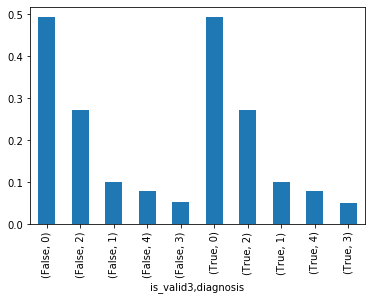

Distribution of 2019 Fold 4 Train/Valid

is_valid4  diagnosis
False      0            0.492670
           2            0.272758
           1            0.100921
           4            0.080805
           3            0.052847
True       0            0.493827
           2            0.272977
           1            0.101509
           4            0.079561
           3            0.052126
Name: diagnosis, dtype: float64


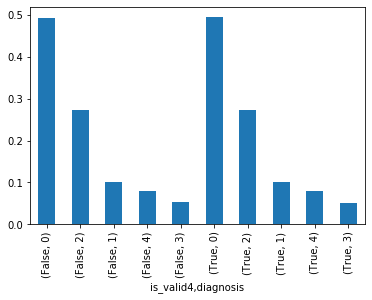

Distribution of 2019 Fold 5 Train/Valid

is_valid5  diagnosis
False      0            0.492670
           2            0.272758
           1            0.100921
           4            0.080805
           3            0.052847
True       0            0.493827
           2            0.272977
           1            0.101509
           4            0.079561
           3            0.052126
Name: diagnosis, dtype: float64


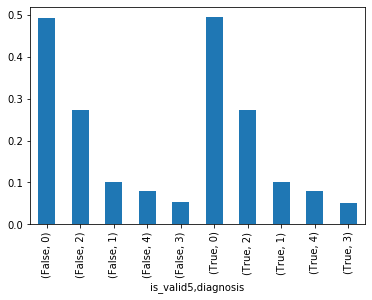

In [6]:
for i in range(1, 6):
    print("Distribution of 2019 Fold {} Train/Valid\n".format(i))
    print(df_2019.groupby("is_valid"+str(i))["diagnosis"].value_counts("True"))
    df_2019.groupby("is_valid"+str(i))["diagnosis"].value_counts("True").plot("bar")
    plt.show()

# Image Size

In [7]:
def get_img_short_size(path):
    image = cv2.imread(path)
    w, h, c = image.shape
    
    return w if w < h else h

In [10]:
# 耗时操作
df_2019["short_size"] = df_2019["path"].apply(get_img_short_size)
df_2019["short_size"].describe()

count    3662.000000
mean     1526.830147
std       542.663120
min       358.000000
25%      1050.000000
50%      1536.000000
75%      1958.000000
max      2848.000000
Name: short_size, dtype: float64

In [31]:
# 更耗时操作
df_2015["short_size"] = df_2015["path"].apply(get_img_short_size)
df_2015["short_size"].describe()

count    35126.000000
mean       702.352929
std         39.767900
min        289.000000
25%        683.000000
50%        683.000000
75%        683.000000
max       1024.000000
Name: short_size, dtype: float64

# Preprocessing

In [8]:
WORKERS = 2
CHANNEL = 3

IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [9]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

(3112,) (3112,) (550,) (550,)


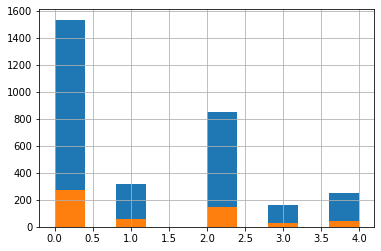

In [10]:
# 
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

## 2019 Train 抽样查看原始训练集图像

CPU times: user 2min 47s, sys: 13.2 s, total: 3min 1s
Wall time: 6 s


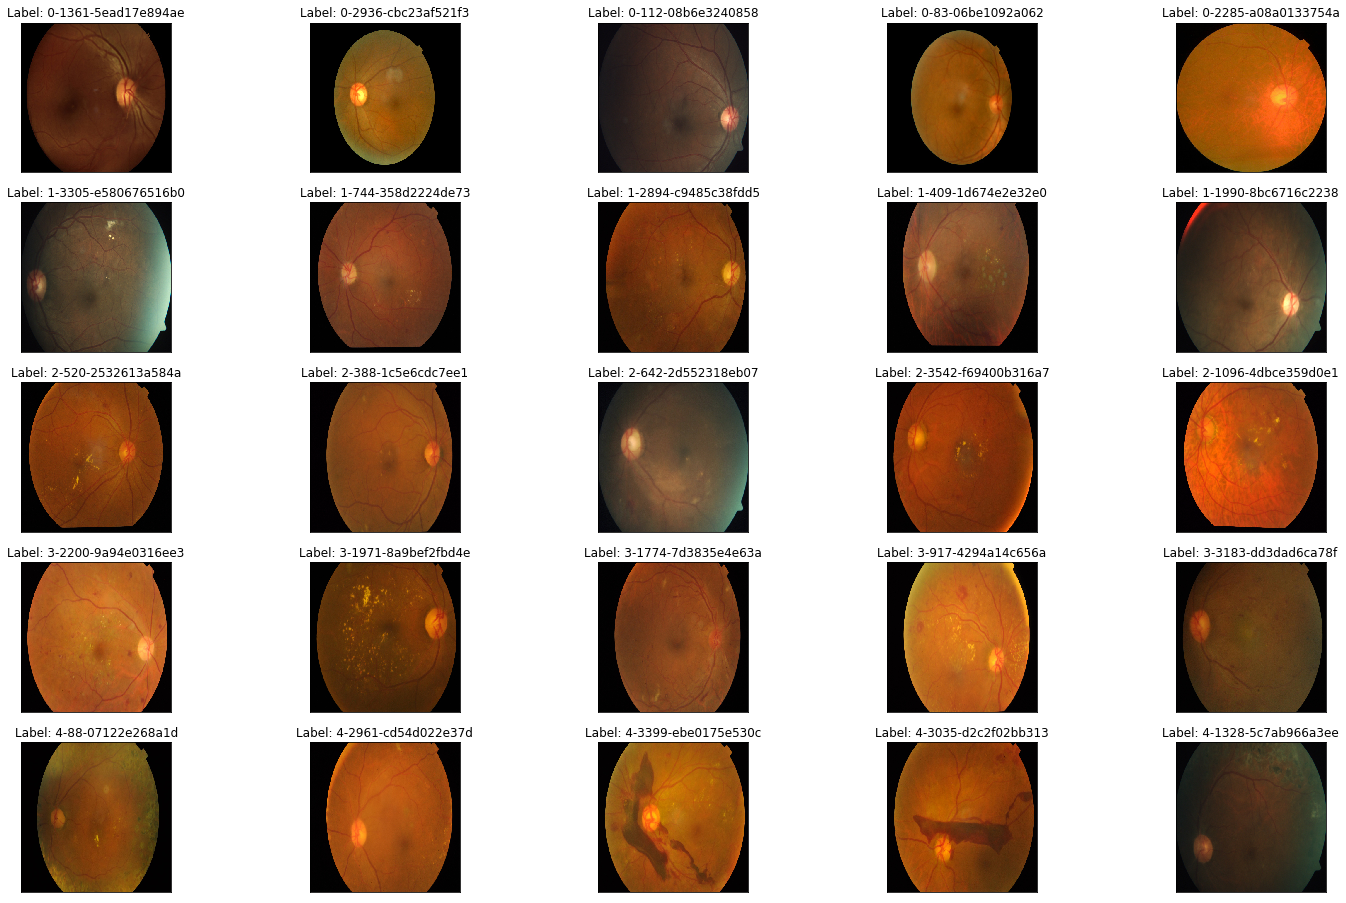

In [11]:
%%time
## Raw

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

CPU times: user 57.1 s, sys: 3.75 s, total: 1min
Wall time: 1.61 s


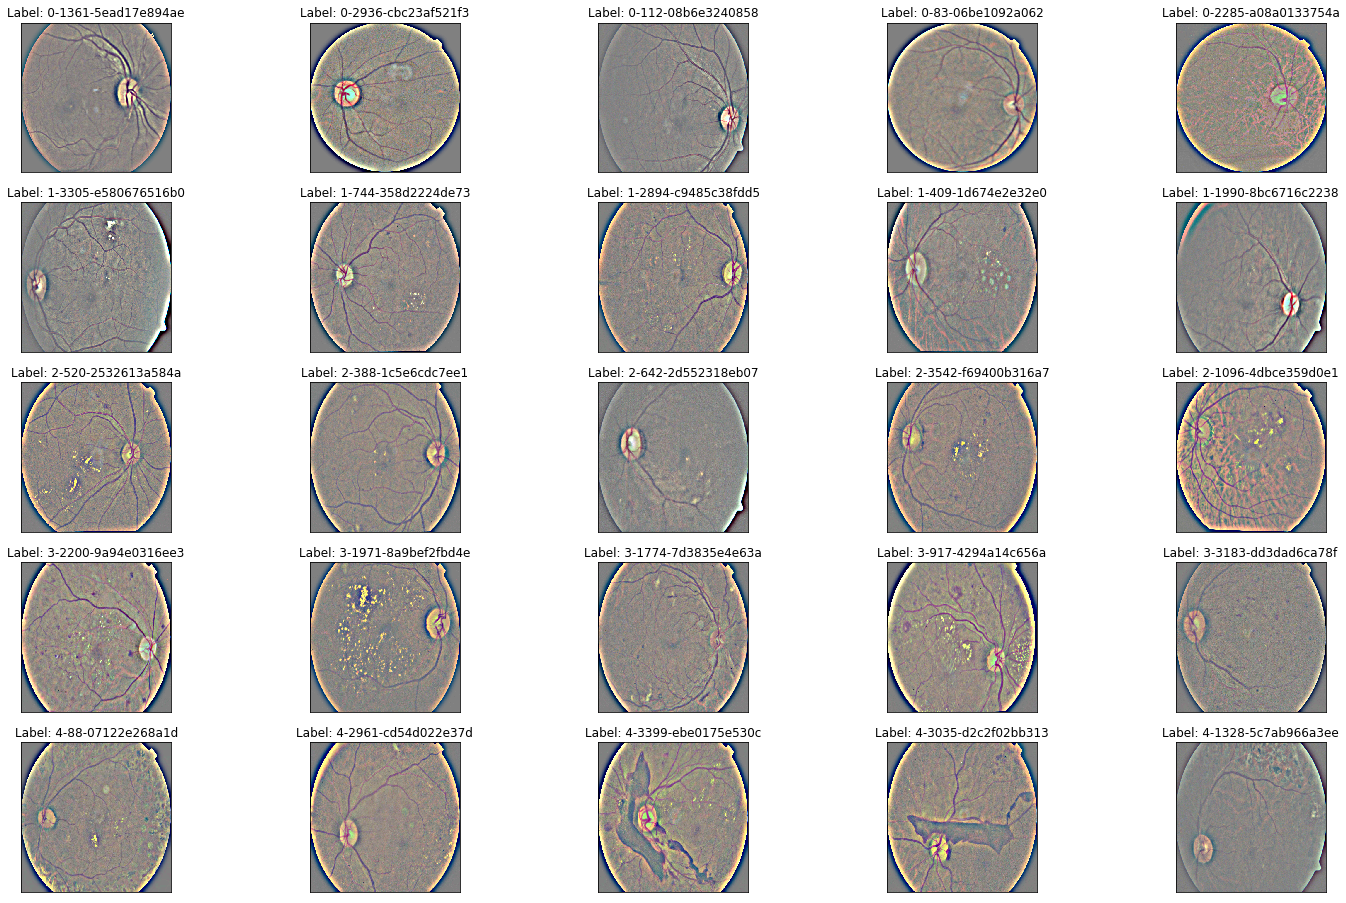

In [12]:
%%time
## Ben's Preprocessing sigmaX=10

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images_ben_preprocessing_sigmaX10/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

## 2019 test  抽样查看原始测试集图像

CPU times: user 1min 17s, sys: 5.27 s, total: 1min 22s
Wall time: 2.28 s


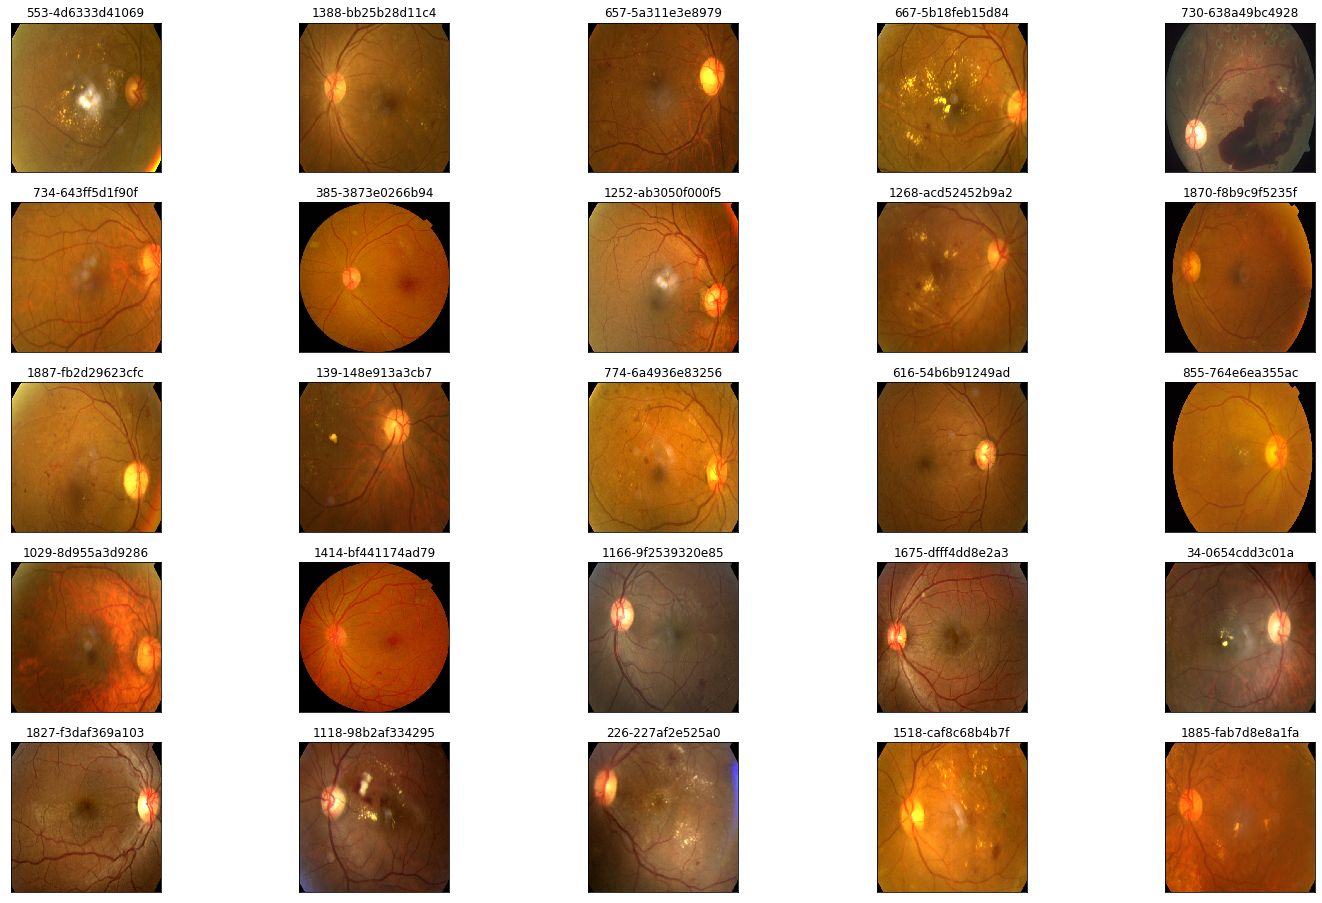

In [13]:
%%time
## Raw

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image)
    ax.set_title('%d-%s' % (idx, row['id_code']) )

CPU times: user 46.4 s, sys: 3.41 s, total: 49.8 s
Wall time: 1.31 s


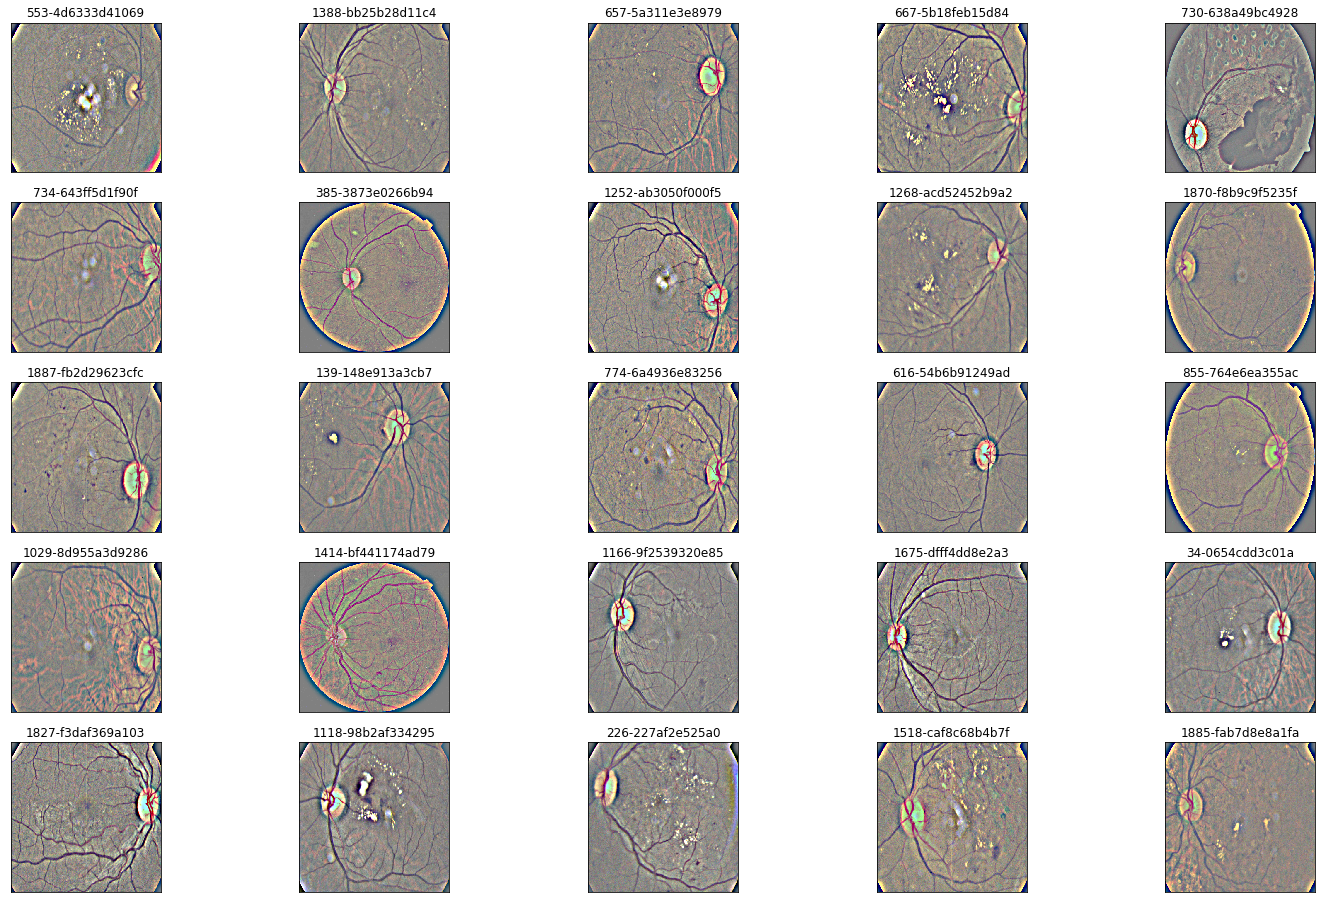

In [14]:
%%time
## Ben's Preprocessing sigmaX=10

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    path=f"../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10/{row['id_code']}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image)
    ax.set_title('%d-%s' % (idx, row['id_code']) )